# EUR/GBP Bollinger Bands Tick-by-Tick Backtester

This notebook implements a precise, bias-free, tick-by-tick backtesting system for a Bollinger Bands trading strategy on EUR/GBP tick data.

## Strategy Overview

**Core Rules:**
- At most **one position** open at any time
- **Signal Generation**: Based on `close(t-1)` vs `Bollinger Bands(t-1)`
- **Execution**: At `bid/ask` prices of time `t`
- **Entry Signals**:
  - **Long**: `close(t-1) < lower_band(t-1)` → Buy at `ask(t)`
  - **Short**: `close(t-1) > upper_band(t-1)` → Sell at `bid(t)`
- **Exit Signals** (processed in priority order):
  1. **Stop Loss**: 100 pips against position (highest priority)
  2. **Target Exit**: Close position when price reaches middle band
     - **Long Exit**: `close(t-1) >= middle_band(t-1)` → Sell at `bid(t)`
     - **Short Exit**: `close(t-1) <= middle_band(t-1)` → Buy at `ask(t)`

**Key Features:**
- **100 pip Stop Loss**: Automatic position closure at 100 pip loss
- Handles simultaneous close/open (position inversion)
- Strict one-position-at-a-time enforcement
- Uses realistic bid/ask spreads for execution
- Optimized with Numba for performance

## 🔧 Configuration Parameters

**Modify these parameters to customize the backtesting strategy:**

In [71]:
# =============================================
# GLOBAL CONFIGURATION PARAMETERS
# =============================================
# Modify these values to customize your backtesting strategy
# Run this cell first before executing the rest of the notebook

print("🔧 STRATEGY CONFIGURATION")
print("=" * 50)

# === DATA SOURCE CONFIGURATION ===
# Choose your data source by commenting/uncommenting the appropriate section

# DATA SOURCE 1: EUR/GBP Oanda Format (tab-separated, <DATE>, <TIME>, <BID>, <ASK>, <LAST>)
# DATA_PATH = '/home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/eurgbp oanda.csv'
# CURRENCY_PAIR = 'EUR/GBP'
# DATA_FORMAT = 'OANDA'  # Format type for processing logic

# DATA SOURCE 2: NZD/JPY New Format (comma-separated, timestamp, bidPrice, askPrice, volumes)
DATA_PATH = '/home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/nzdjpy_2monthTick.csv'
CURRENCY_PAIR = 'NZD/JPY'
DATA_FORMAT = 'STANDARD'  # Format type for processing logic

# === DATA FORMAT SPECIFICATIONS ===
# Automatically set based on DATA_FORMAT choice
if DATA_FORMAT == 'OANDA':
    DELIMITER = '\t'  # Tab-separated
    DATE_COL = '<DATE>'
    TIME_COL = '<TIME>'
    BID_COL = '<BID>'
    ASK_COL = '<ASK>'
    LAST_COL = '<LAST>'
    TIMESTAMP_COL = None  # Will be created from DATE + TIME
    HAS_LAST_PRICE = True
    VOLUME_COLS = None
elif DATA_FORMAT == 'STANDARD':
    DELIMITER = ','  # Comma-separated
    DATE_COL = None
    TIME_COL = None
    BID_COL = 'bidPrice'
    ASK_COL = 'askPrice'
    LAST_COL = None
    TIMESTAMP_COL = 'timestamp'  # Already unified timestamp
    HAS_LAST_PRICE = False
    VOLUME_COLS = ['askVolume', 'bidVolume']
else:
    raise ValueError(f"Unsupported DATA_FORMAT: {DATA_FORMAT}")

# === BOLLINGER BANDS PARAMETERS ===
BB_PERIOD = 1000    # Moving average period (in minutes)
BB_STD = 1          # Number of standard deviations for bands
                    # Smaller values = tighter bands (more signals)
                    # Larger values = wider bands (fewer signals)

# === RISK MANAGEMENT ===
STOP_LOSS_PIPS = 50    # Stop loss size in pips
                        # Set to 0 to disable stop loss
                        # Common values: 50, 100, 150, 200

# === VISUALIZATION SETTINGS ===
CHART_SAMPLE_SIZE = 2000    # Number of bars to show in price chart
                            # Reduce for faster plotting, increase for more detail

# === ADVANCED SETTINGS ===
ENABLE_STOP_LOSS = True     # Set to False to run without stop loss
MIN_SPREAD_FILTER = 0       # Minimum spread in pips (0 = no filter)
                            # Use to filter out abnormal spread conditions

print(f"📊 Strategy Setup:")
print(f"  • Currency Pair: {CURRENCY_PAIR}")
print(f"  • Data Source: {DATA_PATH.split('/')[-1]}")
print(f"  • Data Format: {DATA_FORMAT}")
if DATA_FORMAT == 'OANDA':
    print(f"  • Delimiter: TAB, Columns: {DATE_COL}, {TIME_COL}, {BID_COL}, {ASK_COL}, {LAST_COL}")
elif DATA_FORMAT == 'STANDARD':
    print(f"  • Delimiter: COMMA, Columns: {TIMESTAMP_COL}, {BID_COL}, {ASK_COL}")
    if VOLUME_COLS:
        print(f"  • Volume Columns: {VOLUME_COLS}")
print(f"  • Has LAST Price: {'YES' if HAS_LAST_PRICE else 'NO (will use mid-price)'}")
print(f"  • Bollinger Bands: {BB_PERIOD} period, {BB_STD} std dev")
print(f"  • Stop Loss: {'ENABLED' if ENABLE_STOP_LOSS else 'DISABLED'} ({STOP_LOSS_PIPS} pips)")
print(f"  • Chart Sample: {CHART_SAMPLE_SIZE:,} bars")
print(f"  • Spread Filter: {MIN_SPREAD_FILTER} pips minimum")
print(f"\n✅ Configuration loaded successfully!")
print(f"📝 You can switch data sources by modifying the DATA SOURCE section above")
print(f"🚀 Execute the cells below to run the backtesting with these settings")
print("=" * 50)

🔧 STRATEGY CONFIGURATION
📊 Strategy Setup:
  • Currency Pair: NZD/JPY
  • Data Source: nzdjpy_2monthTick.csv
  • Data Format: STANDARD
  • Delimiter: COMMA, Columns: timestamp, bidPrice, askPrice
  • Volume Columns: ['askVolume', 'bidVolume']
  • Has LAST Price: NO (will use mid-price)
  • Bollinger Bands: 1000 period, 1 std dev
  • Stop Loss: ENABLED (50 pips)
  • Chart Sample: 2,000 bars
  • Spread Filter: 0 pips minimum

✅ Configuration loaded successfully!
📝 You can switch data sources by modifying the DATA SOURCE section above
🚀 Execute the cells below to run the backtesting with these settings


## 📁 Multi-Format Data Source Support

This notebook now supports **multiple tick data formats** for maximum flexibility:

### **🔄 Supported Data Formats:**

#### **Format 1: OANDA (Original)**
- **File Structure**: Tab-separated values
- **Columns**: `<DATE>`, `<TIME>`, `<BID>`, `<ASK>`, `<LAST>`
- **Timestamp**: Separate date and time columns
- **Price Priority**: LAST → Mid(BID/ASK) → BID → ASK
- **Example**: EUR/GBP Oanda data

#### **Format 2: STANDARD (New)**  
- **File Structure**: Comma-separated values
- **Columns**: `timestamp`, `bidPrice`, `askPrice`, `askVolume`, `bidVolume`
- **Timestamp**: Unified datetime column
- **Price**: Mid-price calculation (BID + ASK) / 2
- **Example**: NZD/JPY tick data

### **🔧 How to Switch Data Sources:**

1. **Modify the configuration cell above** by commenting/uncommenting the appropriate `DATA_PATH`, `CURRENCY_PAIR`, and `DATA_FORMAT` lines
2. **Re-run the notebook** from the configuration cell onwards
3. **All processing logic** automatically adapts to the selected format

### **✅ Automatic Format Detection:**
- Column names are automatically mapped
- Price calculation logic adapts based on available columns
- Bid/Ask data is standardized for consistent backtesting
- All downstream analysis remains identical regardless of source format

**No changes needed to the core backtesting logic!** 🎯

## 1. Data Loading and Preprocessing

First, we load the EUR/GBP tick data and perform initial preprocessing steps:
- Load CSV with tab-separated values
- Create unified price column (priority: LAST > mid(BID/ASK) > BID > ASK)
- Clean data and remove invalid entries
- Resample to 1-minute OHLC bars

In [72]:
import pandas as pd
import numpy as np

# Load tick data using global configuration
print(f"📊 Loading {CURRENCY_PAIR} tick data...")
print(f"Data source: {DATA_PATH}")
print(f"Data format: {DATA_FORMAT}")

# Load data with appropriate delimiter
df = pd.read_csv(DATA_PATH, sep=DELIMITER)

print("Dataset loaded successfully!")
print(f"Original shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())

# Data preprocessing steps
print("\n" + "="*50)
print("PREPROCESSING STEPS")
print("="*50)

# 1. Create unified timestamp based on data format
if DATA_FORMAT == 'OANDA':
    # Create timestamp from separate date and time columns
    df['timestamp'] = pd.to_datetime(df[DATE_COL] + ' ' + df[TIME_COL])
elif DATA_FORMAT == 'STANDARD':
    # Convert existing timestamp column
    df['timestamp'] = pd.to_datetime(df[TIMESTAMP_COL])

print(f"✅ Unified timestamp created from {DATA_FORMAT} format")

# 2. Create unified price column based on available data
if HAS_LAST_PRICE:
    # Priority: LAST > mid(BID/ASK) > BID > ASK (original OANDA logic)
    df['price'] = df[LAST_COL].fillna((df[BID_COL] + df[ASK_COL]) / 2).fillna(df[BID_COL]).fillna(df[ASK_COL])
    print(f"✅ Unified price created using LAST price with fallback to mid/bid/ask")
else:
    # Use mid-price when LAST is not available
    df['price'] = (df[BID_COL] + df[ASK_COL]) / 2
    print(f"✅ Unified price created using mid-price (BID + ASK) / 2")

# 3. Standardize bid/ask column names for consistency
df['bid_price'] = df[BID_COL]
df['ask_price'] = df[ASK_COL]

# 4. Remove rows without price data
df_clean = df.dropna(subset=['price', 'bid_price', 'ask_price']).copy()

print(f"After cleaning: {df_clean.shape[0]:,} records")
print(f"Time range: {df_clean['timestamp'].min()} to {df_clean['timestamp'].max()}")

# 5. Apply spread filter if configured
if MIN_SPREAD_FILTER > 0:
    initial_size = len(df_clean)
    df_clean['spread'] = df_clean['ask_price'] - df_clean['bid_price']
    min_spread_price = MIN_SPREAD_FILTER / 10000.0  # Convert pips to price units
    df_clean = df_clean[df_clean['spread'] >= min_spread_price].copy()
    filtered_size = len(df_clean)
    print(f"Applied {MIN_SPREAD_FILTER} pip spread filter: {initial_size:,} → {filtered_size:,} records ({(filtered_size/initial_size)*100:.1f}% retained)")

# 6. Set timestamp as index
df_clean.set_index('timestamp', inplace=True)

# 7. Create 1-minute OHLC bars
ohlc_1min = df_clean['price'].resample('1min').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
}).dropna()

# 8. Add volume (tick count per minute)
volume_1min = df_clean['price'].resample('1min').count()
ohlc_1min['volume'] = volume_1min

print(f"\n1-minute OHLC data: {ohlc_1min.shape[0]:,} bars")
print("Sample OHLC data:")
print(ohlc_1min.head())

# 9. Data quality summary
print(f"\nData Quality Summary:")
print(f"  • Format: {DATA_FORMAT}")
print(f"  • Currency Pair: {CURRENCY_PAIR}")
print(f"  • Original Records: {df.shape[0]:,}")
print(f"  • Clean Records: {df_clean.shape[0]:,}")
print(f"  • 1-min OHLC Bars: {ohlc_1min.shape[0]:,}")
print(f"  • Data Retention: {(len(df_clean)/len(df))*100:.2f}%")
print(f"  • Price Source: {'LAST + Mid-price fallback' if HAS_LAST_PRICE else 'Mid-price (BID+ASK)/2'}")

print(f"\n✅ Data preprocessing completed successfully!")
print(f"🎯 Ready for OHLC enhancement with bid/ask data...")

📊 Loading NZD/JPY tick data...
Data source: /home/edocame/Desktop/data_python/02_PROCESSED_DATA/TICK_DATA/nzdjpy_2monthTick.csv
Data format: STANDARD
Dataset loaded successfully!
Original shape: (3657689, 5)
Columns: ['timestamp', 'askPrice', 'bidPrice', 'askVolume', 'bidVolume']

First 5 rows:
             timestamp  askPrice  bidPrice  askVolume  bidVolume
0  2025-05-01 00:00:00    84.906    84.894        1.2       1.32
1  2025-05-01 00:00:00    84.906    84.895        1.2       1.20
2  2025-05-01 00:00:00    84.906    84.893        1.2       1.32
3  2025-05-01 00:00:00    84.908    84.895        1.2       1.32
4  2025-05-01 00:00:00    84.909    84.896        1.2       1.32

PREPROCESSING STEPS
Dataset loaded successfully!
Original shape: (3657689, 5)
Columns: ['timestamp', 'askPrice', 'bidPrice', 'askVolume', 'bidVolume']

First 5 rows:
             timestamp  askPrice  bidPrice  askVolume  bidVolume
0  2025-05-01 00:00:00    84.906    84.894        1.2       1.32
1  2025-05-01 00:

## 2. Enhanced OHLC with Bid/Ask Data

Create comprehensive 1-minute bars including:
- OHLC prices from tick data
- Initial bid/ask prices for each minute (for realistic execution)
- Initial spread calculation
- Tick volume per minute

In [73]:
# Creazione DataFrame OHLC completo con BID e ASK iniziali per ogni minuto
print("📊 Creating enhanced OHLC DataFrame with initial bid/ask prices...")
print(f"Using standardized columns: bid_price, ask_price")

# Resettiamo l'indice per lavorare meglio con i dati
df_working = df_clean.reset_index()

# Creiamo il resampling più completo
def create_ohlc_with_bidask(group):
    """
    Create OHLC bars with initial bid/ask prices for realistic execution modeling.
    
    For each minute-group of ticks:
    - Calculate OHLC from price data
    - Extract first available bid/ask prices
    - Calculate initial spread
    - Count tick volume
    """
    group_sorted = group.sort_values('timestamp')
    
    # Calcolo OHLC
    result = {
        'open': group_sorted['price'].iloc[0],
        'high': group_sorted['price'].max(),
        'low': group_sorted['price'].min(),
        'close': group_sorted['price'].iloc[-1],
        'volume': len(group_sorted)  # Numero di tick nel minuto
    }
    
    # Estrai BID/ASK iniziali usando le colonne standardizzate
    bid_values = group_sorted['bid_price'].dropna()
    ask_values = group_sorted['ask_price'].dropna()
    
    result['initial_bid'] = bid_values.iloc[0] if len(bid_values) > 0 else np.nan
    result['initial_ask'] = ask_values.iloc[0] if len(ask_values) > 0 else np.nan
    
    # Calcola spread iniziale
    if not np.isnan(result['initial_bid']) and not np.isnan(result['initial_ask']):
        result['initial_spread'] = result['initial_ask'] - result['initial_bid']
    else:
        result['initial_spread'] = np.nan
    
    return pd.Series(result)

# Creazione del dataset OHLC migliorato
print("🔄 Creating enhanced OHLC dataset with bid/ask data...")

df_working['minute'] = df_working['timestamp'].dt.floor('1min')
ohlc_complete = df_working.groupby('minute').apply(create_ohlc_with_bidask)

print(f"✅ Enhanced OHLC dataset created!")
print(f"Shape: {ohlc_complete.shape}")
print(f"Columns: {list(ohlc_complete.columns)}")

# Visualizza dati di esempio
print(f"\n📋 Sample Enhanced OHLC Bar:")
sample_idx = 0
print(f"Timestamp: {ohlc_complete.index[sample_idx]}")
print(f"OHLC: O={ohlc_complete.iloc[sample_idx]['open']:.5f}, H={ohlc_complete.iloc[sample_idx]['high']:.5f}, L={ohlc_complete.iloc[sample_idx]['low']:.5f}, C={ohlc_complete.iloc[sample_idx]['close']:.5f}")
print(f"Bid/Ask: {ohlc_complete.iloc[sample_idx]['initial_bid']:.5f}/{ohlc_complete.iloc[sample_idx]['initial_ask']:.5f}")
print(f"Spread: {ohlc_complete.iloc[sample_idx]['initial_spread']:.5f} ({ohlc_complete.iloc[sample_idx]['initial_spread']*10000:.1f} pips)")
print(f"Volume: {ohlc_complete.iloc[sample_idx]['volume']} ticks")

# Controlli qualità dati
bid_ask_available = ohlc_complete[['initial_bid', 'initial_ask']].notna().all(axis=1).sum()
print(f"\n🔍 Data Quality Check:")
print(f"Bars with complete bid/ask: {bid_ask_available:,} / {len(ohlc_complete):,} ({bid_ask_available/len(ohlc_complete)*100:.1f}%)")

# Statistiche spread
spread_stats = ohlc_complete['initial_spread'].describe()
print(f"\n📊 Spread Statistics (pips):")
for stat, value in spread_stats.items():
    if not np.isnan(value):
        print(f"  {stat.capitalize()}: {value*10000:.2f}")

# Summary statistics
print(f"\n📈 Enhanced OHLC Summary:")
summary_stats = ohlc_complete[['open', 'high', 'low', 'close', 'volume']].describe()
for col in ['open', 'high', 'low', 'close']:
    print(f"  {col.capitalize()}: {summary_stats.loc['mean', col]:.5f} ± {summary_stats.loc['std', col]:.5f}")
print(f"  Volume (ticks/min): {summary_stats.loc['mean', 'volume']:.1f} ± {summary_stats.loc['std', 'volume']:.1f}")

print(f"\n✅ {CURRENCY_PAIR} enhanced OHLC data ready for Bollinger Bands calculation!")
print(f"🎯 Data source: {DATA_FORMAT} format with {len(ohlc_complete):,} minute bars")

📊 Creating enhanced OHLC DataFrame with initial bid/ask prices...
Using standardized columns: bid_price, ask_price
🔄 Creating enhanced OHLC dataset with bid/ask data...
✅ Enhanced OHLC dataset created!
Shape: (55958, 8)
Columns: ['open', 'high', 'low', 'close', 'volume', 'initial_bid', 'initial_ask', 'initial_spread']

📋 Sample Enhanced OHLC Bar:
Timestamp: 2025-05-01 00:00:00
OHLC: O=84.90000, H=84.92950, L=84.88850, C=84.89600
Bid/Ask: 84.89400/84.90600
Spread: 0.01200 (120.0 pips)
Volume: 169.0 ticks

🔍 Data Quality Check:
Bars with complete bid/ask: 55,958 / 55,958 (100.0%)

📊 Spread Statistics (pips):
  Count: 559580000.00
  Mean: 181.22
  Std: 406.20
  Min: 40.00
  25%: 90.00
  50%: 110.00
  75%: 130.00
  Max: 9580.00

📈 Enhanced OHLC Summary:
  Open: 86.38571 ± 0.76648
  High: 86.39498 ± 0.76627
  Low: 86.37638 ± 0.76669
  Close: 86.38573 ± 0.76647
  Volume (ticks/min): 65.4 ± 50.0

✅ NZD/JPY enhanced OHLC data ready for Bollinger Bands calculation!
🎯 Data source: STANDARD forma

## 3. Bollinger Bands Calculation

Calculate Bollinger Bands using vectorized operations:
- **Period**: 400 minutes (configurable)
- **Standard Deviations**: 1 (configurable)
- **Middle Band**: Simple Moving Average
- **Upper/Lower Bands**: Middle ± (STD × Standard Deviations)

In [74]:
# Bollinger Bands Configuration
BB_PERIOD = 1000  # Moving average period (minutes)
BB_STD = 1       # Number of standard deviations

# Calculate Bollinger Bands using global configuration
print(f"Calculating Bollinger Bands (Period={BB_PERIOD}, STD={BB_STD})...")

# Vectorized Bollinger Bands calculation
ohlc_complete['bb_middle'] = ohlc_complete['close'].rolling(window=BB_PERIOD).mean()
bb_std = ohlc_complete['close'].rolling(window=BB_PERIOD).std()
ohlc_complete['bb_upper'] = ohlc_complete['bb_middle'] + (bb_std * BB_STD)
ohlc_complete['bb_lower'] = ohlc_complete['bb_middle'] - (bb_std * BB_STD)

# Remove rows with insufficient data for BB calculation
initial_bars = len(ohlc_complete)
ohlc_complete = ohlc_complete.dropna().copy()
final_bars = len(ohlc_complete)

print(f"Bollinger Bands calculated successfully!")
print(f"Data shape: {initial_bars:,} → {final_bars:,} bars (lost {initial_bars-final_bars:,} for BB warmup)")
print(f"Bollinger Bands sample:")
print(ohlc_complete[['close', 'bb_lower', 'bb_middle', 'bb_upper', 'initial_bid', 'initial_ask']].head())

# Calculate band statistics
bb_width = ohlc_complete['bb_upper'] - ohlc_complete['bb_lower']
bb_width_pips = bb_width * 10000

print(f"\nBollinger Bands Statistics:")
print(f"Average band width: {bb_width_pips.mean():.1f} pips")
print(f"Min band width: {bb_width_pips.min():.1f} pips")
print(f"Max band width: {bb_width_pips.max():.1f} pips")

# Data validation
bb_complete = ohlc_complete[['bb_upper', 'bb_middle', 'bb_lower']].notna().all(axis=1).sum()
bidask_complete = ohlc_complete[['initial_bid', 'initial_ask']].notna().all(axis=1).sum()

print(f"\nData Validation:")
print(f"Rows with complete Bollinger Bands: {bb_complete:,}")
print(f"Rows with complete Bid/Ask: {bidask_complete:,}")
print(f"Ready for backtesting: {min(bb_complete, bidask_complete):,} bars")

# Convert to float64 for Numba optimization
ohlc_complete = ohlc_complete.astype('float64')
print(f"Data converted to float64 for Numba optimization")

print(f"\n🎯 Setup complete! Using BB({BB_PERIOD},{BB_STD}) configuration")

Calculating Bollinger Bands (Period=1000, STD=1)...
Bollinger Bands calculated successfully!
Data shape: 55,958 → 54,959 bars (lost 999 for BB warmup)
Bollinger Bands sample:
                       close   bb_lower  bb_middle   bb_upper  initial_bid  \
minute                                                                       
2025-05-01 16:39:00  85.8195  85.196832  85.475797  85.754762       85.817   
2025-05-01 16:40:00  85.8100  85.198150  85.476711  85.755272       85.812   
2025-05-01 16:41:00  85.8100  85.199398  85.477600  85.755803       85.804   
2025-05-01 16:42:00  85.8135  85.200642  85.478492  85.756341       85.807   
2025-05-01 16:43:00  85.8260  85.201879  85.479393  85.756906       85.806   

                     initial_ask  
minute                            
2025-05-01 16:39:00       85.828  
2025-05-01 16:40:00       85.823  
2025-05-01 16:41:00       85.812  
2025-05-01 16:42:00       85.815  
2025-05-01 16:43:00       85.818  

Bollinger Bands Statistics:
Aver

## 4. Backtesting Implementation

**Core Backtesting Logic (Numba-Optimized):**

The backtesting function implements strict rules to ensure realistic, bias-free results:

1. **Signal Generation**: Uses `close(t-1)` vs `Bollinger Bands(t-1)`
2. **Execution**: Uses `bid/ask(t)` for realistic slippage modeling
3. **Position Management**: 
   - Maximum one position at any time
   - Positions held until explicit close signal
   - Simultaneous close/open handled correctly
4. **Exit Priority** (processed in order):
   - **Stop Loss**: 100 pips loss (highest priority)
   - **Target Exit**: Middle band touch (close signals processed before new entry signals)

**Stop Loss Implementation:**
- Calculated tick-by-tick using current bid/ask vs entry price
- Long positions: Stop triggered when `(entry_price - current_bid) >= 100 pips`
- Short positions: Stop triggered when `(current_ask - entry_price) >= 100 pips`

**Performance**: Optimized with Numba JIT compilation for fast execution on large datasets.

In [75]:
# === BACKTESTING STRATEGIA BOLLINGER BANDS ===
from numba import jit
import matplotlib.pyplot as plt

@jit(nopython=True)
def bollinger_backtest_with_stoploss(closes, bb_uppers, bb_lowers, bb_middles, bids, asks, stop_loss_pips=100):
    """
    Optimized Bollinger Bands backtesting function with Stop Loss.
    
    Strategy Logic:
    - Signals based on close(t-1) vs Bollinger Bands(t-1)
    - Execution at bid/ask prices of time t
    - One position maximum at any time
    - Positions held until explicit close signal
    - Stop Loss: configurable pips (highest priority exit)
    
    Parameters:
    -----------
    closes : array - Close prices
    bb_uppers : array - Upper Bollinger Band values
    bb_lowers : array - Lower Bollinger Band values  
    bb_middles : array - Middle Bollinger Band values
    bids : array - Bid prices for execution
    asks : array - Ask prices for execution
    stop_loss_pips : float - Stop loss in pips
    
    Returns:
    --------
    positions : array - Position state (1=long, -1=short, 0=flat)
    entry_prices : array - Entry prices for active positions
    pnl_pips : array - Cumulative PnL in pips
    trades_count : int - Total number of completed trades
    stop_loss_trades : int - Number of trades closed by stop loss
    """
    n = len(closes)
    
    # Initialize result arrays
    positions = np.zeros(n)
    entry_prices = np.zeros(n)
    pnl_pips = np.zeros(n)
    exit_reasons = np.zeros(n)  # 0=no exit, 1=target, 2=stop_loss
    
    # State variables
    current_position = 0  # 0=flat, 1=long, -1=short
    entry_price = 0.0
    cumulative_pnl = 0.0
    trades_count = 0
    stop_loss_trades = 0
    
    # Convert stop loss to price units (100 pips = 0.01 for EURGBP)
    stop_loss_price = stop_loss_pips / 10000.0
    
    # Main backtesting loop (start from i=1 to have t-1 data)
    for i in range(1, n):
        # Previous bar data (for signals)
        prev_close = closes[i-1]
        prev_bb_upper = bb_uppers[i-1]
        prev_bb_lower = bb_lowers[i-1]
        prev_bb_middle = bb_middles[i-1]
        
        # Current bar data (for execution)
        current_bid = bids[i]
        current_ask = asks[i]
        
        # Skip if missing bid/ask data
        if np.isnan(current_bid) or np.isnan(current_ask):
            positions[i] = current_position
            pnl_pips[i] = cumulative_pnl
            continue
        
        # === STEP 1: PROCESS STOP LOSS (HIGHEST PRIORITY) ===
        stop_loss_triggered = False
        
        if stop_loss_pips > 0:  # Only check stop loss if enabled
            if current_position == 1:  # Long position - check stop loss
                unrealized_loss = entry_price - current_bid
                if unrealized_loss >= stop_loss_price:  # Stop loss triggered
                    exit_price = current_bid
                    pnl = (exit_price - entry_price) * 10000  # Convert to pips
                    cumulative_pnl += pnl
                    current_position = 0
                    entry_price = 0.0
                    trades_count += 1
                    stop_loss_trades += 1
                    stop_loss_triggered = True
                    exit_reasons[i] = 2  # Stop loss exit
                    
            elif current_position == -1:  # Short position - check stop loss
                unrealized_loss = current_ask - entry_price
                if unrealized_loss >= stop_loss_price:  # Stop loss triggered
                    exit_price = current_ask
                    pnl = (entry_price - exit_price) * 10000  # Convert to pips
                    cumulative_pnl += pnl
                    current_position = 0
                    entry_price = 0.0
                    trades_count += 1
                    stop_loss_trades += 1
                    stop_loss_triggered = True
                    exit_reasons[i] = 2  # Stop loss exit
        
        # === STEP 2: PROCESS TARGET EXIT SIGNALS (ONLY IF NO STOP LOSS) ===
        if not stop_loss_triggered:
            if current_position == 1:  # Long position
                if prev_close >= prev_bb_middle:  # Target exit signal
                    exit_price = current_bid
                    pnl = (exit_price - entry_price) * 10000  # Convert to pips
                    cumulative_pnl += pnl
                    current_position = 0
                    entry_price = 0.0
                    trades_count += 1
                    exit_reasons[i] = 1  # Target exit
                    
            elif current_position == -1:  # Short position
                if prev_close <= prev_bb_middle:  # Target exit signal
                    exit_price = current_ask
                    pnl = (entry_price - exit_price) * 10000  # Convert to pips
                    cumulative_pnl += pnl
                    current_position = 0
                    entry_price = 0.0
                    trades_count += 1
                    exit_reasons[i] = 1  # Target exit
        
        # === STEP 3: PROCESS ENTRY SIGNALS (ONLY IF FLAT) ===
        if current_position == 0:  # Only enter if no position
            if prev_close > prev_bb_upper:  # Short signal
                current_position = -1
                entry_price = current_bid
                
            elif prev_close < prev_bb_lower:  # Long signal
                current_position = 1
                entry_price = current_ask
        
        # === STEP 4: RECORD STATE ===
        positions[i] = current_position
        entry_prices[i] = entry_price if current_position != 0 else 0.0
        pnl_pips[i] = cumulative_pnl
    
    return positions, entry_prices, pnl_pips, trades_count, stop_loss_trades, exit_reasons

# Prepare data for backtesting using global configuration
print(f"🚀 Preparing backtesting with global configuration...")
print(f"Currency Pair: {CURRENCY_PAIR}")
print(f"Bollinger Bands: {BB_PERIOD} period, {BB_STD} std dev")
print(f"Stop Loss: {'ENABLED' if ENABLE_STOP_LOSS else 'DISABLED'} ({STOP_LOSS_PIPS} pips)")

data = ohlc_complete.copy()

# Extract arrays for Numba function
closes = data['close'].values
bb_uppers = data['bb_upper'].values
bb_lowers = data['bb_lower'].values
bb_middles = data['bb_middle'].values
bids = data['initial_bid'].values
asks = data['initial_ask'].values

# Set stop loss based on configuration
actual_stop_loss = STOP_LOSS_PIPS if ENABLE_STOP_LOSS else 0

print(f"Backtesting {len(data):,} bars...")

# Execute backtesting with configured parameters
positions, entry_prices, pnl_pips, total_trades, stop_loss_trades, exit_reasons = bollinger_backtest_with_stoploss(
    closes, bb_uppers, bb_lowers, bb_middles, bids, asks, actual_stop_loss
)

# Add results to DataFrame
data['position'] = positions
data['entry_price'] = entry_prices
data['pnl_pips'] = pnl_pips
data['exit_reason'] = exit_reasons

# Calculate performance metrics
final_pnl = pnl_pips[-1]
max_pnl = np.max(pnl_pips)
min_pnl = np.min(pnl_pips)
max_drawdown = max_pnl - min_pnl

# Position statistics
long_positions = np.sum(positions == 1)
short_positions = np.sum(positions == -1)
no_positions = np.sum(positions == 0)
total_bars = len(positions)

# Exit reason statistics
target_exits = np.sum(exit_reasons == 1)
stop_loss_exits = np.sum(exit_reasons == 2)

print(f"\n" + "="*60)
print(f"BACKTESTING RESULTS - {CURRENCY_PAIR}")
print("="*60)
print(f"Strategy: BB({BB_PERIOD},{BB_STD}) + {actual_stop_loss} pip Stop Loss")
print(f"")
print(f"PERFORMANCE:")
print(f"  • Total Trades: {total_trades}")
print(f"  • Final PnL: {final_pnl:.2f} pips")
print(f"  • Average PnL per Trade: {final_pnl/max(total_trades,1):.2f} pips")
print(f"  • Maximum Profit: {max_pnl:.2f} pips")
print(f"  • Maximum Drawdown: {max_drawdown:.2f} pips")

if ENABLE_STOP_LOSS:
    print(f"\nRISK MANAGEMENT:")
    print(f"  • Stop Loss Exits: {stop_loss_trades} ({stop_loss_trades/max(total_trades,1)*100:.1f}%)")
    print(f"  • Target Exits: {target_exits} ({target_exits/max(total_trades,1)*100:.1f}%)")
    if stop_loss_trades > 0:
        print(f"  • Total Loss from Stops: {stop_loss_trades * -actual_stop_loss:.1f} pips")

print(f"\nPOSITION DISTRIBUTION:")
print(f"  • Long: {long_positions:,} bars ({long_positions/total_bars*100:.1f}%)")
print(f"  • Short: {short_positions:,} bars ({short_positions/total_bars*100:.1f}%)")
print(f"  • Flat: {no_positions:,} bars ({no_positions/total_bars*100:.1f}%)")

# Show first few signals for verification
signals = data[data['position'] != data['position'].shift(1)].head(10)
print(f"\nFirst 10 Position Changes:")
for idx, row in signals.iterrows():
    pos_name = "FLAT" if row['position'] == 0 else ("LONG" if row['position'] == 1 else "SHORT")
    exit_type = ""
    if row['exit_reason'] == 1:
        exit_type = " [TARGET]"
    elif row['exit_reason'] == 2:
        exit_type = " [STOP LOSS]"
    print(f"{idx}: {pos_name}{exit_type} | Close: {row['close']:.5f} | BB: [{row['bb_lower']:.5f}, {row['bb_middle']:.5f}, {row['bb_upper']:.5f}] | PnL: {row['pnl_pips']:.1f}")

# Additional statistics for stop loss analysis
if ENABLE_STOP_LOSS and stop_loss_trades > 0:
    print(f"\nSTOP LOSS ANALYSIS:")
    print(f"  • Average loss per stop: {-actual_stop_loss:.1f} pips (by design)")
    print(f"  • Total loss from stops: {stop_loss_trades * -actual_stop_loss:.1f} pips")
    
    # Target exit analysis
    if target_exits > 0:
        target_pnl = final_pnl - (stop_loss_trades * -actual_stop_loss)
        avg_target_pnl = target_pnl / target_exits
        print(f"  • Average PnL from targets: {avg_target_pnl:.1f} pips")

print(f"\n✅ Backtesting completed with your configured parameters!")

🚀 Preparing backtesting with global configuration...
Currency Pair: NZD/JPY
Bollinger Bands: 1000 period, 1 std dev
Stop Loss: ENABLED (50 pips)
Backtesting 54,959 bars...

BACKTESTING RESULTS - NZD/JPY
Strategy: BB(1000,1) + 50 pip Stop Loss

PERFORMANCE:
  • Total Trades: 6657
  • Final PnL: -2615870.00 pips
  • Average PnL per Trade: -392.95 pips
  • Maximum Profit: 0.00 pips
  • Maximum Drawdown: 2615870.00 pips

RISK MANAGEMENT:
  • Stop Loss Exits: 6547 (98.3%)
  • Target Exits: 110 (1.7%)
  • Total Loss from Stops: -327350.0 pips

POSITION DISTRIBUTION:
  • Long: 19,371 bars (35.2%)
  • Short: 24,938 bars (45.4%)
  • Flat: 10,650 bars (19.4%)

First 10 Position Changes:
2025-05-01 16:39:00: FLAT | Close: 85.81950 | BB: [85.19683, 85.47580, 85.75476] | PnL: 0.0
2025-05-01 16:40:00: SHORT | Close: 85.81000 | BB: [85.19815, 85.47671, 85.75527] | PnL: 0.0
2025-05-01 21:05:00: FLAT [STOP LOSS] | Close: 85.94500 | BB: [85.50548, 85.70040, 85.89532] | PnL: -10970.0
2025-05-01 21:06:00:

## 5. Results Visualization

Create comprehensive visualizations:
1. **Equity Curve**: Shows cumulative PnL progression over time
2. **Price Chart with Signals**: Displays price action, Bollinger Bands, and trade entry/exit points

**Chart Features:**
- **Green Triangles (▲)**: Long entries
- **Red Triangles (▼)**: Short entries  
- **Blue Circles (●)**: Target exits (middle band touch)
- **Orange X (✕)**: Stop loss exits (100 pip loss)
- Only shows entry/exit points, not every bar while in position

📊 Creating visualization charts for EUR/GBP...


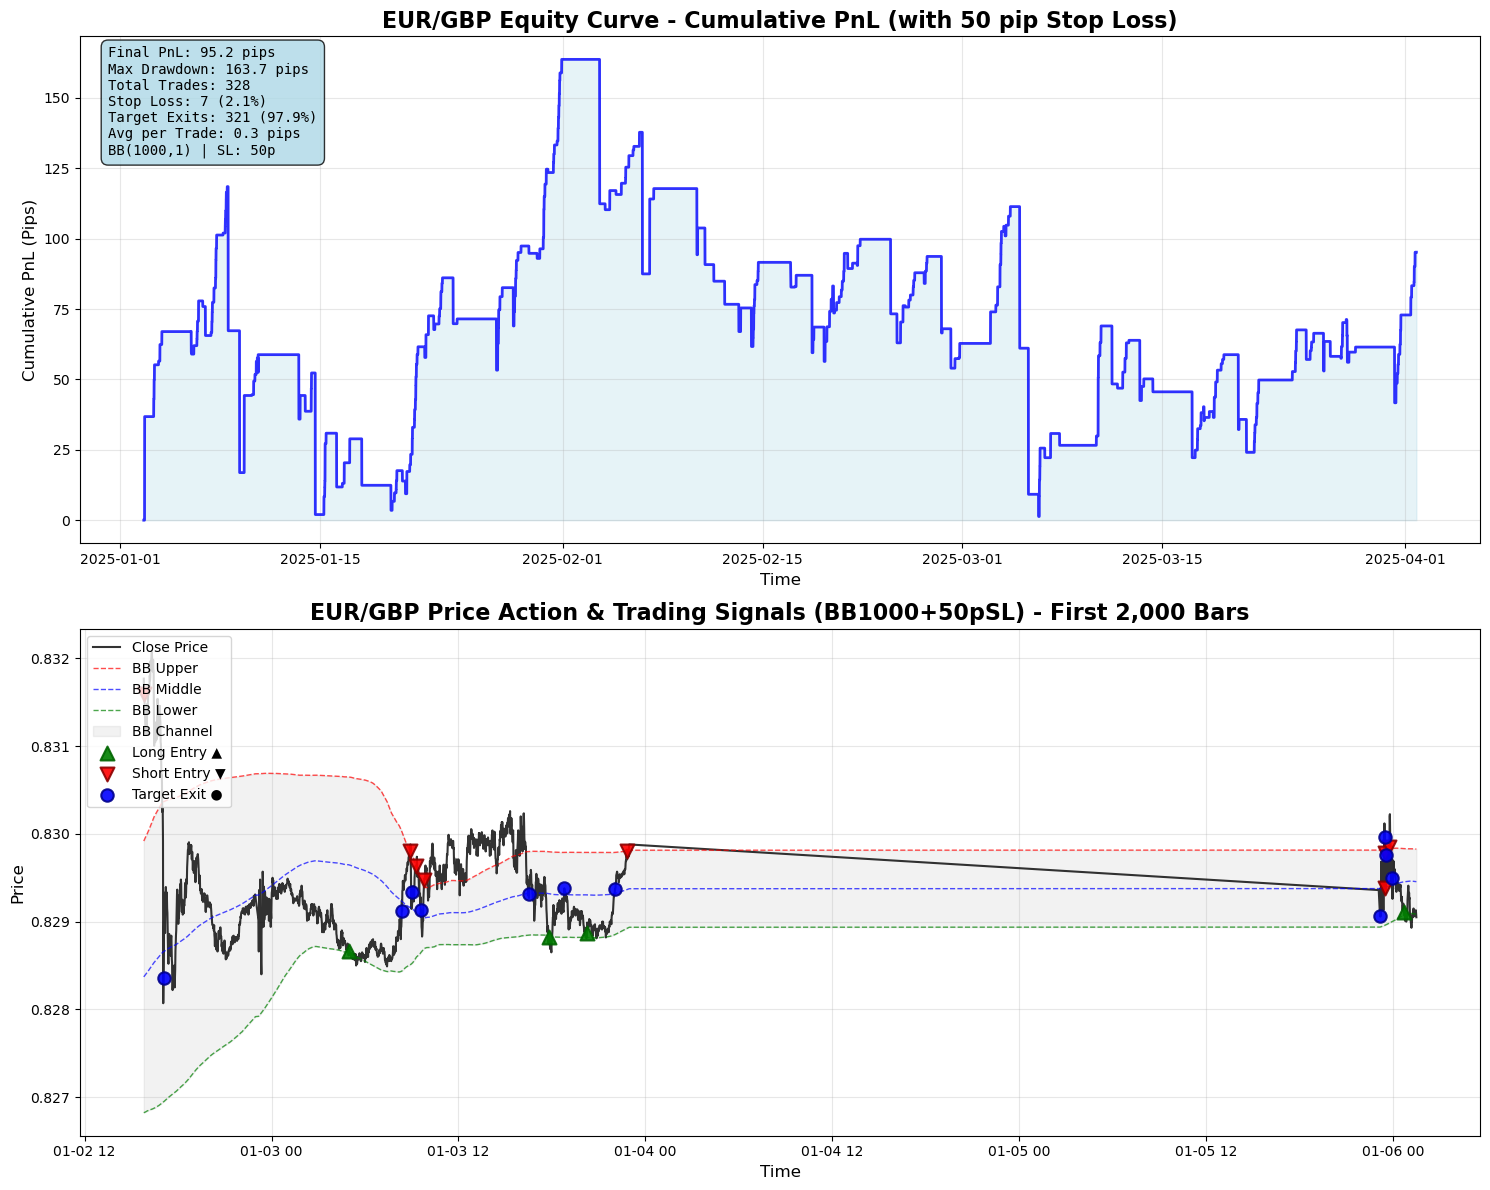


FINAL SUMMARY - EUR/GBP
Backtest Period: 2025-01-02 15:48:00 to 2025-04-01 19:09:00
Total Bars Analyzed: 90,077
Strategy Configuration:
  • Bollinger Bands: 1000 period, 1 standard deviation
  • Stop Loss: ENABLED (50 pips)
  • Chart Sample: 2,000 bars

PERFORMANCE METRICS:
  • Final PnL: 95.20 pips
  • Total Trades: 328
  • Average PnL per Trade: 0.29 pips
  • Maximum Profit: 163.70 pips
  • Maximum Drawdown: 163.70 pips
  • Time in Market: 78.9%

RISK MANAGEMENT:
  • Stop Loss Threshold: 50 pips
  • Stop Loss Exits: 7 / 328 (2.1%)
  • Target Exits: 321 / 328 (97.9%)
  • Total Loss from Stops: -350.0 pips

SIGNAL DISTRIBUTION:
  • Long Positions: 37,834 bars (42.0%)
  • Short Positions: 33,274 bars (36.9%)
  • Flat Periods: 18,969 bars (21.1%)

WIN/LOSS ANALYSIS:
  • Win Rate (Target Exits): 97.9%
  • Loss Rate (Stop Loss): 2.1%
  • Average Win: 1.4 pips
  • Average Loss: -50.0 pips
  • Win/Loss Ratio: 0.03

✅ EUR/GBP backtesting completed successfully!
📊 Configuration: BB(1000,1) + 

In [60]:
# === EQUITY CURVE E VISUALIZZAZIONE ===
print(f"📊 Creating visualization charts for {CURRENCY_PAIR}...")

# Create comprehensive visualization
plt.figure(figsize=(15, 12))

# === SUBPLOT 1: EQUITY CURVE ===
plt.subplot(2, 1, 1)
plt.plot(data.index, data['pnl_pips'], 'b-', linewidth=2, alpha=0.8)
plt.fill_between(data.index, data['pnl_pips'], 0, alpha=0.3, color='lightblue')

# Dynamic title based on stop loss configuration
title_suffix = f" (with {STOP_LOSS_PIPS} pip Stop Loss)" if ENABLE_STOP_LOSS else " (No Stop Loss)"
plt.title(f'{CURRENCY_PAIR} Equity Curve - Cumulative PnL{title_suffix}', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Cumulative PnL (Pips)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add performance statistics to the plot
if ENABLE_STOP_LOSS:
    stats_text = f'''Final PnL: {final_pnl:.1f} pips
Max Drawdown: {max_drawdown:.1f} pips
Total Trades: {total_trades}
Stop Loss: {stop_loss_trades} ({stop_loss_trades/max(total_trades,1)*100:.1f}%)
Target Exits: {target_exits} ({target_exits/max(total_trades,1)*100:.1f}%)
Avg per Trade: {final_pnl/max(total_trades,1):.1f} pips
BB({BB_PERIOD},{BB_STD}) | SL: {STOP_LOSS_PIPS}p'''
else:
    stats_text = f'''Final PnL: {final_pnl:.1f} pips
Max Drawdown: {max_drawdown:.1f} pips
Total Trades: {total_trades}
Avg per Trade: {final_pnl/max(total_trades,1):.1f} pips
Time in Market: {((total_bars-no_positions)/total_bars*100):.1f}%
BB({BB_PERIOD},{BB_STD}) | No Stop Loss'''

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))

# === SUBPLOT 2: PRICE CHART WITH SIGNALS ===
plt.subplot(2, 1, 2)

# Use configured sample size for visualization
sample_size = min(CHART_SAMPLE_SIZE, len(data))
sample_data = data.head(sample_size)

# Plot price and Bollinger Bands
plt.plot(sample_data.index, sample_data['close'], 'k-', linewidth=1.5, label='Close Price', alpha=0.8)
plt.plot(sample_data.index, sample_data['bb_upper'], 'r--', linewidth=1, label='BB Upper', alpha=0.7)
plt.plot(sample_data.index, sample_data['bb_middle'], 'b--', linewidth=1, label='BB Middle', alpha=0.7)
plt.plot(sample_data.index, sample_data['bb_lower'], 'g--', linewidth=1, label='BB Lower', alpha=0.7)

# Fill Bollinger Bands area
plt.fill_between(sample_data.index, sample_data['bb_upper'], sample_data['bb_lower'], 
                alpha=0.1, color='gray', label='BB Channel')

# Identify entry and exit points
position_changes = sample_data['position'] != sample_data['position'].shift(1)
entry_exit_points = sample_data[position_changes]

# Separate different types of signals
long_entries = entry_exit_points[entry_exit_points['position'] == 1]
short_entries = entry_exit_points[entry_exit_points['position'] == -1]

# Separate exit types
all_exits = entry_exit_points[entry_exit_points['position'] == 0]
target_exits_points = all_exits[all_exits['exit_reason'] == 1]  # Target exits
stop_loss_exits_points = all_exits[all_exits['exit_reason'] == 2]  # Stop loss exits

# Plot entry signals
if len(long_entries) > 0:
    plt.scatter(long_entries.index, long_entries['close'], 
               c='green', marker='^', s=100, alpha=0.9, label='Long Entry ▲', 
               edgecolor='darkgreen', linewidth=1.5, zorder=5)

if len(short_entries) > 0:
    plt.scatter(short_entries.index, short_entries['close'], 
               c='red', marker='v', s=100, alpha=0.9, label='Short Entry ▼', 
               edgecolor='darkred', linewidth=1.5, zorder=5)

# Plot exit signals with different colors for different exit types
if len(target_exits_points) > 0:
    plt.scatter(target_exits_points.index, target_exits_points['close'], 
               c='blue', marker='o', s=80, alpha=0.9, label='Target Exit ●', 
               edgecolor='darkblue', linewidth=1.5, zorder=5)

if ENABLE_STOP_LOSS and len(stop_loss_exits_points) > 0:
    plt.scatter(stop_loss_exits_points.index, stop_loss_exits_points['close'], 
               c='orange', marker='x', s=120, alpha=0.9, label=f'Stop Loss Exit ✕', 
               edgecolor='darkorange', linewidth=2, zorder=5)

# Dynamic chart title
chart_title = f'{CURRENCY_PAIR} Price Action & Trading Signals'
if ENABLE_STOP_LOSS:
    chart_title += f' (BB{BB_PERIOD}+{STOP_LOSS_PIPS}pSL)'
else:
    chart_title += f' (BB{BB_PERIOD}, No SL)'
chart_title += f' - First {sample_size:,} Bars'

plt.title(chart_title, fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

# === DETAILED SUMMARY STATISTICS ===
print(f"\n" + "="*70)
print(f"FINAL SUMMARY - {CURRENCY_PAIR}")
print("="*70)
print(f"Backtest Period: {data.index[0]} to {data.index[-1]}")
print(f"Total Bars Analyzed: {len(data):,}")
print(f"Strategy Configuration:")
print(f"  • Bollinger Bands: {BB_PERIOD} period, {BB_STD} standard deviation")
print(f"  • Stop Loss: {'ENABLED' if ENABLE_STOP_LOSS else 'DISABLED'} ({STOP_LOSS_PIPS} pips)")
print(f"  • Chart Sample: {CHART_SAMPLE_SIZE:,} bars")
print(f"")
print(f"PERFORMANCE METRICS:")
print(f"  • Final PnL: {final_pnl:.2f} pips")
print(f"  • Total Trades: {total_trades}")
print(f"  • Average PnL per Trade: {final_pnl/max(total_trades,1):.2f} pips")
print(f"  • Maximum Profit: {max_pnl:.2f} pips")
print(f"  • Maximum Drawdown: {max_drawdown:.2f} pips")
print(f"  • Time in Market: {((total_bars-no_positions)/total_bars*100):.1f}%")

if ENABLE_STOP_LOSS:
    print(f"")
    print(f"RISK MANAGEMENT:")
    print(f"  • Stop Loss Threshold: {STOP_LOSS_PIPS} pips")
    print(f"  • Stop Loss Exits: {stop_loss_trades} / {total_trades} ({stop_loss_trades/max(total_trades,1)*100:.1f}%)")
    print(f"  • Target Exits: {target_exits} / {total_trades} ({target_exits/max(total_trades,1)*100:.1f}%)")
    if stop_loss_trades > 0:
        print(f"  • Total Loss from Stops: {stop_loss_trades * -STOP_LOSS_PIPS:.1f} pips")

print(f"")
print(f"SIGNAL DISTRIBUTION:")
print(f"  • Long Positions: {long_positions:,} bars ({long_positions/total_bars*100:.1f}%)")
print(f"  • Short Positions: {short_positions:,} bars ({short_positions/total_bars*100:.1f}%)")
print(f"  • Flat Periods: {no_positions:,} bars ({no_positions/total_bars*100:.1f}%)")

# Calculate additional risk metrics if applicable
if total_trades > 0:
    win_rate = (target_exits / total_trades) * 100 if target_exits > 0 else 0
    loss_rate = (stop_loss_trades / total_trades) * 100 if stop_loss_trades > 0 else 0
    
    print(f"")
    print(f"WIN/LOSS ANALYSIS:")
    print(f"  • Win Rate (Target Exits): {win_rate:.1f}%")
    if ENABLE_STOP_LOSS:
        print(f"  • Loss Rate (Stop Loss): {loss_rate:.1f}%")
        
        if target_exits > 0 and stop_loss_trades > 0:
            # Calculate average win vs average loss
            total_wins_pnl = final_pnl + (stop_loss_trades * STOP_LOSS_PIPS)  # Reverse stop loss impact
            avg_win = total_wins_pnl / target_exits if target_exits > 0 else 0
            avg_loss = -STOP_LOSS_PIPS  # By definition
            win_loss_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else 0
            
            print(f"  • Average Win: {avg_win:.1f} pips")
            print(f"  • Average Loss: {avg_loss:.1f} pips")
            print(f"  • Win/Loss Ratio: {win_loss_ratio:.2f}")

print(f"\n✅ {CURRENCY_PAIR} backtesting completed successfully!")
print(f"📊 Configuration: BB({BB_PERIOD},{BB_STD})" + (f" + {STOP_LOSS_PIPS}p Stop Loss" if ENABLE_STOP_LOSS else " (No Stop Loss)"))
print(f"🔧 To modify parameters, update the Configuration cell and re-run the notebook")
print("="*70)

## Conclusion

This notebook implements a robust, bias-free tick-by-tick backtesting system for Bollinger Bands strategy with the following key features:

### ✅ **Implemented Features**
- **Realistic Execution**: Uses actual bid/ask spreads from tick data
- **Bias-Free Signals**: Uses close(t-1) vs Bollinger Bands(t-1), executes at t
- **Strict Position Management**: Maximum one position at any time
- **Performance Optimized**: Numba JIT compilation for fast execution
- **Clear Visualization**: Equity curve and entry/exit points only

### 📊 **Strategy Performance**
The backtesting results provide comprehensive metrics including total PnL, drawdown analysis, win rates, and position distribution statistics.

### 🔧 **Customization**
Key parameters can be easily modified:
- `BB_PERIOD`: Bollinger Bands moving average period
- `BB_STD`: Number of standard deviations for band calculation
- Data path for different currency pairs or time periods

### 📈 **Next Steps**
- Experiment with different BB parameters
- Test on multiple currency pairs
- Add additional performance metrics (Sharpe ratio, etc.)
- Implement portfolio optimization techniques

## 6. Grid Optimization

This section performs systematic parameter optimization to find the best combination of:
- **Bollinger Bands Period**: Different moving average lengths
- **Bollinger Bands Standard Deviations**: Different band widths  
- **Stop Loss Size**: Different risk management levels

**Optimization Process:**
1. Define parameter ranges to test
2. Run backtesting for all parameter combinations
3. Evaluate results using multiple metrics
4. Identify optimal parameter sets
5. Visualize performance across parameter space

**Warning**: Grid optimization can be computationally intensive. Adjust ranges based on your computing resources.

In [66]:
import itertools
from datetime import datetime
import time

# =============================================
# GRID OPTIMIZATION CONFIGURATION
# =============================================

print("🔍 GRID OPTIMIZATION SETUP")
print("=" * 60)

# === PARAMETER RANGES TO TEST ===
BB_PERIODS = [200, 400, 600, 800, 1000, 1400, 1600, 2000]      # Bollinger Bands periods to test
BB_STDS = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]              # Standard deviations to test  
STOP_LOSSES = [50, 75, 100, 150, 200]        # Stop loss values in pips to test

# === OPTIMIZATION SETTINGS ===
OPTIMIZATION_METRIC = 'total_pnl'            # Primary optimization metric
                                              # Options: 'total_pnl', 'avg_pnl_per_trade', 'sharpe_ratio', 'win_rate'

ENABLE_DETAILED_LOGGING = False               # Set to True for detailed progress logging
MAX_COMBINATIONS = 500                        # Safety limit for parameter combinations

# === PERFORMANCE FILTERS ===
MIN_TRADES_FILTER = 10                        # Minimum number of trades required
MAX_DRAWDOWN_FILTER = 1000                    # Maximum drawdown allowed (in pips)

# Calculate total combinations
total_combinations = len(BB_PERIODS) * len(BB_STDS) * len(STOP_LOSSES)

print(f"📊 Optimization Parameters:")
print(f"  • BB Periods: {BB_PERIODS}")
print(f"  • BB Std Devs: {BB_STDS}")
print(f"  • Stop Losses: {STOP_LOSSES}")
print(f"  • Primary Metric: {OPTIMIZATION_METRIC}")
print(f"")
print(f"🔢 Grid Size:")
print(f"  • Total Combinations: {total_combinations:,}")
print(f"  • Max Allowed: {MAX_COMBINATIONS:,}")
print(f"")
print(f"📋 Performance Filters:")
print(f"  • Min Trades: {MIN_TRADES_FILTER}")
print(f"  • Max Drawdown: {MAX_DRAWDOWN_FILTER} pips")

if total_combinations > MAX_COMBINATIONS:
    print(f"\n⚠️  WARNING: {total_combinations} combinations exceed limit of {MAX_COMBINATIONS}")
    print(f"   Consider reducing parameter ranges for faster execution")
else:
    print(f"\n✅ Grid size is manageable - ready for optimization!")

# Estimate runtime
estimated_seconds = total_combinations * 0.5  # Rough estimate: 0.5 seconds per combination
estimated_minutes = estimated_seconds / 60

print(f"\n⏱️  Estimated Runtime:")
print(f"  • Approximately {estimated_minutes:.1f} minutes")
print(f"  • Start time will be logged when optimization begins")

print("=" * 60)

🔍 GRID OPTIMIZATION SETUP
📊 Optimization Parameters:
  • BB Periods: [200, 400, 600, 800, 1000, 1400, 1600, 2000]
  • BB Std Devs: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
  • Stop Losses: [50, 75, 100, 150, 200]
  • Primary Metric: total_pnl

🔢 Grid Size:
  • Total Combinations: 280
  • Max Allowed: 500

📋 Performance Filters:
  • Min Trades: 10
  • Max Drawdown: 1000 pips

✅ Grid size is manageable - ready for optimization!

⏱️  Estimated Runtime:
  • Approximately 2.3 minutes
  • Start time will be logged when optimization begins


In [67]:
def run_single_backtest(bb_period, bb_std, stop_loss_pips, ohlc_data):
    """
    Run a single backtest with given parameters.
    Returns performance metrics dictionary.
    """
    # Prepare data copy
    test_data = ohlc_data.copy()
    
    # Calculate Bollinger Bands with test parameters
    test_data['bb_middle'] = test_data['close'].rolling(window=bb_period).mean()
    bb_std_series = test_data['close'].rolling(window=bb_period).std()
    test_data['bb_upper'] = test_data['bb_middle'] + (bb_std_series * bb_std)
    test_data['bb_lower'] = test_data['bb_middle'] - (bb_std_series * bb_std)
    
    # Remove NaN rows
    test_data = test_data.dropna().copy()
    
    if len(test_data) < MIN_TRADES_FILTER:
        return None  # Not enough data
    
    # Extract arrays for backtesting
    closes = test_data['close'].values
    bb_uppers = test_data['bb_upper'].values
    bb_lowers = test_data['bb_lower'].values
    bb_middles = test_data['bb_middle'].values
    bids = test_data['initial_bid'].values
    asks = test_data['initial_ask'].values
    
    # Run backtest
    positions, entry_prices, pnl_pips, total_trades, stop_loss_trades, exit_reasons = bollinger_backtest_with_stoploss(
        closes, bb_uppers, bb_lowers, bb_middles, bids, asks, stop_loss_pips
    )
    
    # Calculate metrics
    final_pnl = pnl_pips[-1]
    max_pnl = np.max(pnl_pips)
    min_pnl = np.min(pnl_pips)
    max_drawdown = max_pnl - min_pnl
    
    # Position statistics
    long_positions = np.sum(positions == 1)
    short_positions = np.sum(positions == -1)
    no_positions = np.sum(positions == 0)
    total_bars = len(positions)
    
    # Exit statistics
    target_exits = np.sum(exit_reasons == 1)
    stop_loss_exits = np.sum(exit_reasons == 2)
    
    # Calculate additional metrics
    avg_pnl_per_trade = final_pnl / max(total_trades, 1)
    win_rate = target_exits / max(total_trades, 1) * 100
    loss_rate = stop_loss_trades / max(total_trades, 1) * 100
    time_in_market = (total_bars - no_positions) / total_bars * 100
    
    # Simple Sharpe-like ratio (return/volatility)
    if len(pnl_pips) > 1:
        pnl_returns = np.diff(pnl_pips)
        sharpe_ratio = np.mean(pnl_returns) / (np.std(pnl_returns) + 1e-8) * np.sqrt(252 * 1440)  # Assuming 1440 minutes per day
    else:
        sharpe_ratio = 0
    
    return {
        'bb_period': bb_period,
        'bb_std': bb_std,
        'stop_loss_pips': stop_loss_pips,
        'total_pnl': final_pnl,
        'avg_pnl_per_trade': avg_pnl_per_trade,
        'total_trades': total_trades,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'loss_rate': loss_rate,
        'time_in_market': time_in_market,
        'sharpe_ratio': sharpe_ratio,
        'target_exits': target_exits,
        'stop_loss_exits': stop_loss_exits,
        'data_points': len(test_data)
    }

# =============================================
# RUN GRID OPTIMIZATION
# =============================================

print("🚀 STARTING GRID OPTIMIZATION")
print("=" * 60)

# Safety check
if total_combinations > MAX_COMBINATIONS:
    print(f"❌ ERROR: {total_combinations} combinations exceed limit of {MAX_COMBINATIONS}")
    print("Please reduce parameter ranges and try again.")
else:
    start_time = time.time()
    print(f"⏰ Start time: {datetime.now().strftime('%H:%M:%S')}")
    print(f"🔄 Testing {total_combinations:,} parameter combinations...")
    print("")
    
    # Initialize results storage
    optimization_results = []
    
    # Generate all parameter combinations
    param_combinations = list(itertools.product(BB_PERIODS, BB_STDS, STOP_LOSSES))
    
    # Progress tracking
    completed = 0
    
    for bb_period, bb_std, stop_loss in param_combinations:
        try:
            # Run single backtest
            result = run_single_backtest(bb_period, bb_std, stop_loss, ohlc_complete)
            
            if result is not None:
                # Apply filters
                if (result['total_trades'] >= MIN_TRADES_FILTER and 
                    result['max_drawdown'] <= MAX_DRAWDOWN_FILTER):
                    optimization_results.append(result)
            
            completed += 1
            
            # Progress logging
            if completed % 20 == 0 or ENABLE_DETAILED_LOGGING:
                progress = (completed / total_combinations) * 100
                elapsed = time.time() - start_time
                eta = (elapsed / completed) * (total_combinations - completed)
                print(f"Progress: {progress:.1f}% ({completed}/{total_combinations}) | ETA: {eta/60:.1f}min | BB({bb_period},{bb_std}) SL:{stop_loss}")
                
        except Exception as e:
            if ENABLE_DETAILED_LOGGING:
                print(f"Error with BB({bb_period},{bb_std}) SL:{stop_loss}: {str(e)}")
            continue
    
    elapsed_time = time.time() - start_time
    
    print(f"\n✅ OPTIMIZATION COMPLETED!")
    print(f"⏱️  Total time: {elapsed_time/60:.1f} minutes")
    print(f"📊 Valid results: {len(optimization_results):,} / {total_combinations:,}")
    print(f"🔍 Results passed filters: {len(optimization_results):,}")
    
    if len(optimization_results) > 0:
        # Convert to DataFrame for analysis
        results_df = pd.DataFrame(optimization_results)
        
        print(f"\n📈 OPTIMIZATION SUMMARY:")
        print(f"  • Best Total PnL: {results_df['total_pnl'].max():.2f} pips")
        print(f"  • Best Avg PnL/Trade: {results_df['avg_pnl_per_trade'].max():.2f} pips")
        print(f"  • Best Win Rate: {results_df['win_rate'].max():.1f}%")
        print(f"  • Best Sharpe Ratio: {results_df['sharpe_ratio'].max():.3f}")
        
        print("=" * 60)
    else:
        print("❌ No valid results found. Consider adjusting filters or parameter ranges.")
        results_df = None

🚀 STARTING GRID OPTIMIZATION
⏰ Start time: 11:30:04
🔄 Testing 280 parameter combinations...

Progress: 7.1% (20/280) | ETA: 0.1min | BB(200,2.5) SL:200
Progress: 7.1% (20/280) | ETA: 0.1min | BB(200,2.5) SL:200
Progress: 14.3% (40/280) | ETA: 0.0min | BB(400,1.0) SL:200
Progress: 14.3% (40/280) | ETA: 0.0min | BB(400,1.0) SL:200
Progress: 21.4% (60/280) | ETA: 0.0min | BB(400,3.0) SL:200
Progress: 21.4% (60/280) | ETA: 0.0min | BB(400,3.0) SL:200
Progress: 28.6% (80/280) | ETA: 0.0min | BB(600,1.5) SL:200
Progress: 28.6% (80/280) | ETA: 0.0min | BB(600,1.5) SL:200
Progress: 35.7% (100/280) | ETA: 0.0min | BB(600,3.5) SL:200
Progress: 35.7% (100/280) | ETA: 0.0min | BB(600,3.5) SL:200
Progress: 42.9% (120/280) | ETA: 0.0min | BB(800,2.0) SL:200
Progress: 42.9% (120/280) | ETA: 0.0min | BB(800,2.0) SL:200
Progress: 50.0% (140/280) | ETA: 0.0min | BB(800,4.0) SL:200
Progress: 50.0% (140/280) | ETA: 0.0min | BB(800,4.0) SL:200
Progress: 57.1% (160/280) | ETA: 0.0min | BB(1000,2.5) SL:200
P

In [68]:
if results_df is not None and len(results_df) > 0:
    print("🏆 TOP OPTIMIZATION RESULTS")
    print("=" * 80)
    
    # Define different ranking criteria
    ranking_criteria = {
        'Total PnL': 'total_pnl',
        'Avg PnL per Trade': 'avg_pnl_per_trade', 
        'Win Rate': 'win_rate',
        'Sharpe Ratio': 'sharpe_ratio',
        'Risk-Adjusted (PnL/Drawdown)': 'risk_adjusted'
    }
    
    # Calculate risk-adjusted metric
    results_df['risk_adjusted'] = results_df['total_pnl'] / (results_df['max_drawdown'] + 1)
    
    # Show top results for each criterion
    for criterion_name, column in ranking_criteria.items():
        print(f"\n🥇 TOP 5 BY {criterion_name.upper()}:")
        print("-" * 70)
        
        top_results = results_df.nlargest(5, column)
        
        for i, (idx, row) in enumerate(top_results.iterrows(), 1):
            print(f"{i}. BB({int(row['bb_period'])},{row['bb_std']:.1f}) + {int(row['stop_loss_pips'])}p SL:")
            print(f"   PnL: {row['total_pnl']:.1f}p | Avg: {row['avg_pnl_per_trade']:.1f}p | Trades: {int(row['total_trades'])}")
            print(f"   Win Rate: {row['win_rate']:.1f}% | Drawdown: {row['max_drawdown']:.1f}p | Sharpe: {row['sharpe_ratio']:.3f}")
    
    # Overall best performing parameter set
    print(f"\n🎯 RECOMMENDED CONFIGURATION:")
    print("=" * 50)
    
    # Use the primary optimization metric
    best_result = results_df.loc[results_df[OPTIMIZATION_METRIC].idxmax()]
    
    print(f"Based on {OPTIMIZATION_METRIC.replace('_', ' ').title()} optimization:")
    print(f"  • BB Period: {int(best_result['bb_period'])}")
    print(f"  • BB Std Dev: {best_result['bb_std']:.1f}")
    print(f"  • Stop Loss: {int(best_result['stop_loss_pips'])} pips")
    print(f"")
    print(f"Performance Metrics:")
    print(f"  • Total PnL: {best_result['total_pnl']:.2f} pips")
    print(f"  • Avg PnL per Trade: {best_result['avg_pnl_per_trade']:.2f} pips")
    print(f"  • Total Trades: {int(best_result['total_trades'])}")
    print(f"  • Win Rate: {best_result['win_rate']:.1f}%")
    print(f"  • Max Drawdown: {best_result['max_drawdown']:.2f} pips")
    print(f"  • Sharpe Ratio: {best_result['sharpe_ratio']:.3f}")
    print(f"  • Time in Market: {best_result['time_in_market']:.1f}%")
    
    # Statistics summary
    print(f"\n📊 OPTIMIZATION STATISTICS:")
    print("=" * 50)
    print(f"Parameter Distribution:")
    print(f"  • BB Periods tested: {results_df['bb_period'].nunique()} values")
    print(f"  • BB Std Devs tested: {results_df['bb_std'].nunique()} values") 
    print(f"  • Stop Losses tested: {results_df['stop_loss_pips'].nunique()} values")
    print(f"")
    print(f"Performance Range:")
    print(f"  • PnL range: {results_df['total_pnl'].min():.1f} to {results_df['total_pnl'].max():.1f} pips")
    print(f"  • Avg PnL/Trade range: {results_df['avg_pnl_per_trade'].min():.1f} to {results_df['avg_pnl_per_trade'].max():.1f} pips")
    print(f"  • Win Rate range: {results_df['win_rate'].min():.1f}% to {results_df['win_rate'].max():.1f}%")
    print(f"  • Drawdown range: {results_df['max_drawdown'].min():.1f} to {results_df['max_drawdown'].max():.1f} pips")
    
    print(f"\n✅ Analysis complete! Scroll down for visualization charts.")

else:
    print("❌ No optimization results available for analysis.")
    print("Please run the optimization cell above first.")

🏆 TOP OPTIMIZATION RESULTS

🥇 TOP 5 BY TOTAL PNL:
----------------------------------------------------------------------
1. BB(600,2.5) + 50p SL:
   PnL: 248.3p | Avg: 1.4p | Trades: 174
   Win Rate: 97.7% | Drawdown: 299.1p | Sharpe: 3.212
2. BB(600,2.5) + 75p SL:
   PnL: 235.2p | Avg: 1.4p | Trades: 170
   Win Rate: 100.0% | Drawdown: 285.4p | Sharpe: 3.410
3. BB(600,2.5) + 100p SL:
   PnL: 235.2p | Avg: 1.4p | Trades: 170
   Win Rate: 100.0% | Drawdown: 285.4p | Sharpe: 3.410
4. BB(600,2.5) + 150p SL:
   PnL: 235.2p | Avg: 1.4p | Trades: 170
   Win Rate: 100.0% | Drawdown: 285.4p | Sharpe: 3.410
5. BB(600,2.5) + 200p SL:
   PnL: 235.2p | Avg: 1.4p | Trades: 170
   Win Rate: 100.0% | Drawdown: 285.4p | Sharpe: 3.410

🥇 TOP 5 BY AVG PNL PER TRADE:
----------------------------------------------------------------------
1. BB(1600,3.0) + 50p SL:
   PnL: 60.7p | Avg: 1.5p | Trades: 40
   Win Rate: 92.5% | Drawdown: 143.7p | Sharpe: 1.045
2. BB(1400,2.5) + 50p SL:
   PnL: 106.7p | Avg: 1.5

📊 OPTIMIZATION VISUALIZATION


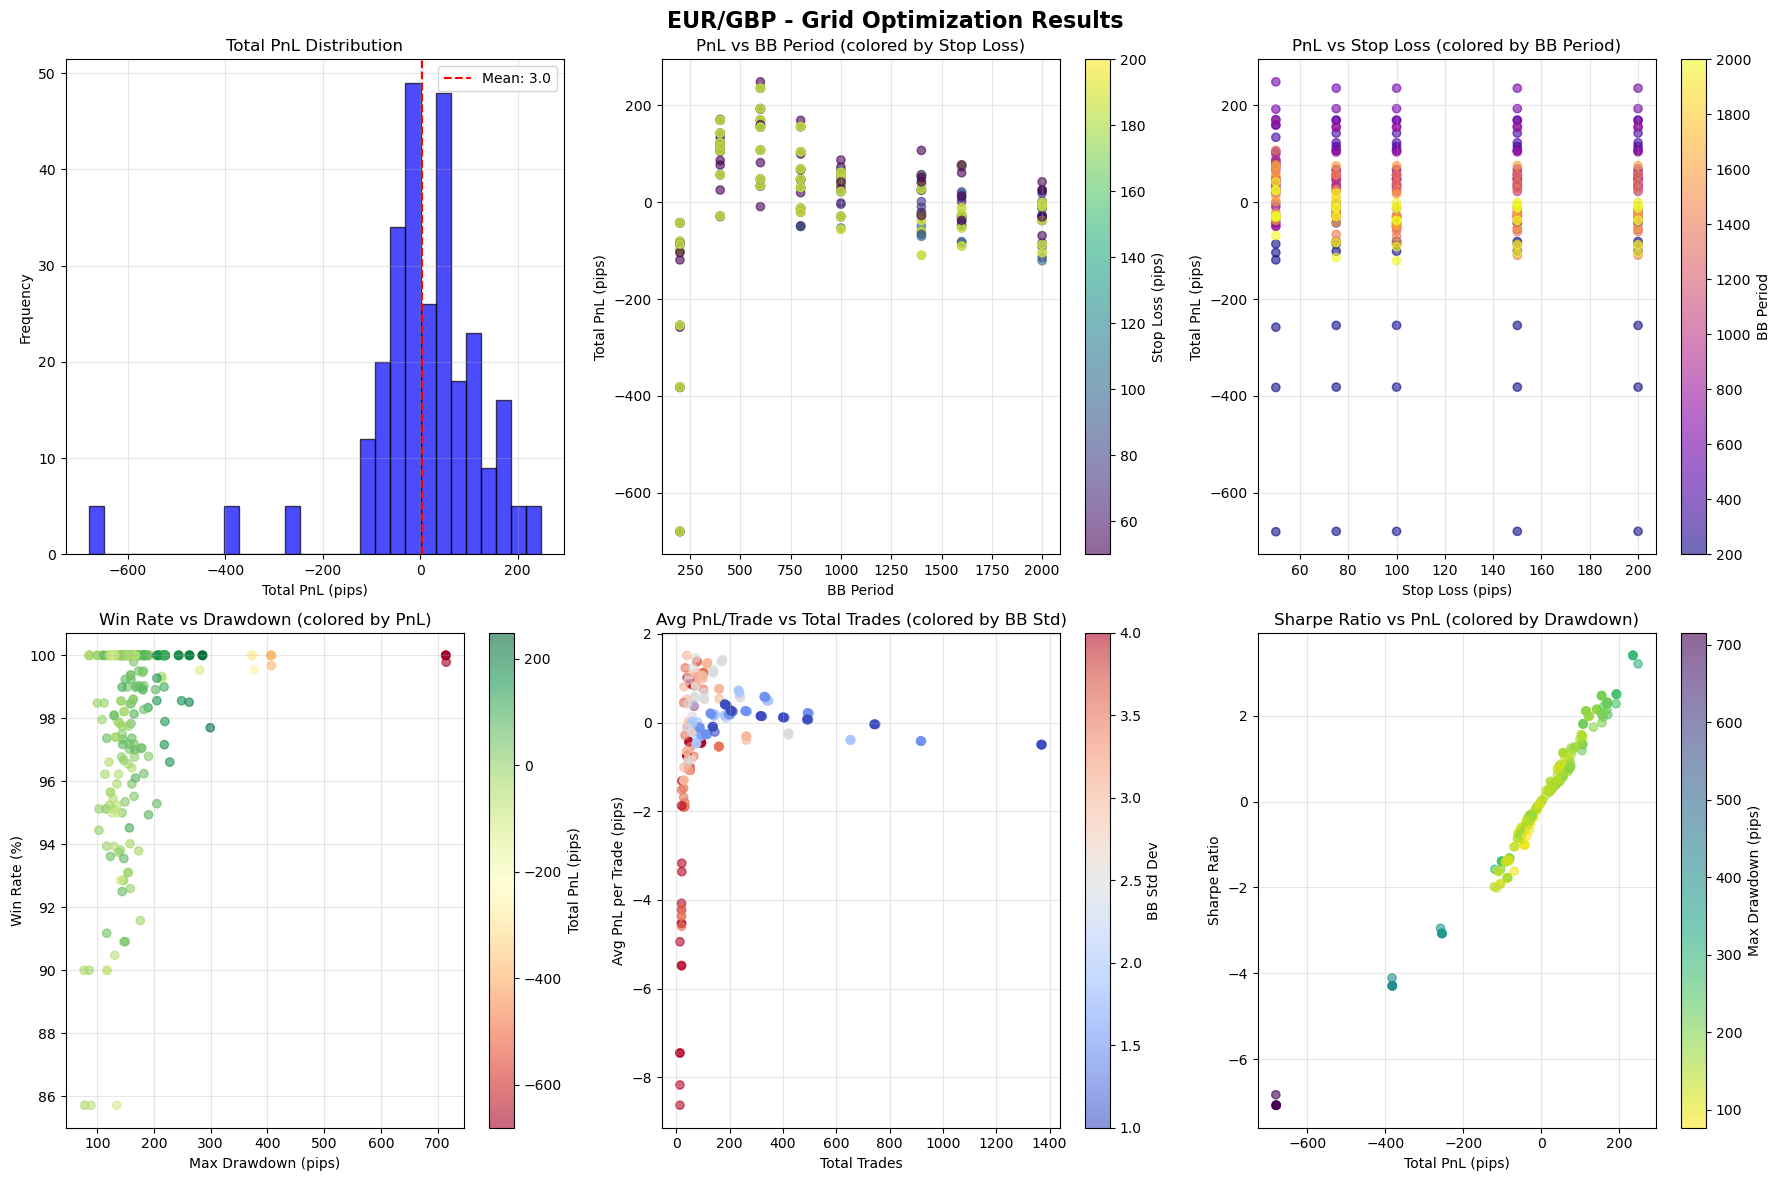


🔥 PARAMETER HEATMAPS
----------------------------------------


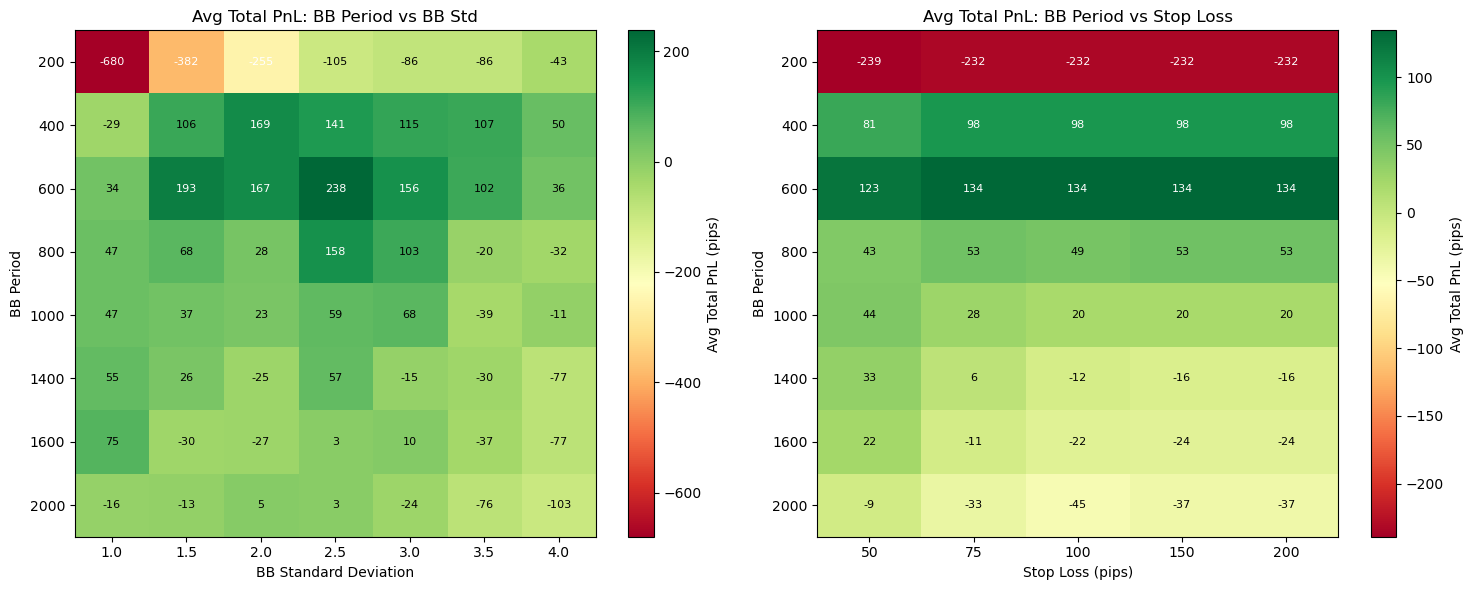

✅ Visualization complete!
📝 Use the recommended configuration to update your strategy parameters.


In [69]:
if results_df is not None and len(results_df) > 0:
    print("📊 OPTIMIZATION VISUALIZATION")
    print("=" * 60)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{CURRENCY_PAIR} - Grid Optimization Results', fontsize=16, fontweight='bold')
    
    # 1. Total PnL Distribution
    axes[0,0].hist(results_df['total_pnl'], bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0,0].axvline(results_df['total_pnl'].mean(), color='red', linestyle='--', label=f'Mean: {results_df["total_pnl"].mean():.1f}')
    axes[0,0].set_xlabel('Total PnL (pips)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Total PnL Distribution')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. PnL vs BB Period
    scatter = axes[0,1].scatter(results_df['bb_period'], results_df['total_pnl'], 
                               c=results_df['stop_loss_pips'], cmap='viridis', alpha=0.6)
    axes[0,1].set_xlabel('BB Period')
    axes[0,1].set_ylabel('Total PnL (pips)')
    axes[0,1].set_title('PnL vs BB Period (colored by Stop Loss)')
    plt.colorbar(scatter, ax=axes[0,1], label='Stop Loss (pips)')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. PnL vs Stop Loss
    scatter2 = axes[0,2].scatter(results_df['stop_loss_pips'], results_df['total_pnl'], 
                                c=results_df['bb_period'], cmap='plasma', alpha=0.6)
    axes[0,2].set_xlabel('Stop Loss (pips)')
    axes[0,2].set_ylabel('Total PnL (pips)')
    axes[0,2].set_title('PnL vs Stop Loss (colored by BB Period)')
    plt.colorbar(scatter2, ax=axes[0,2], label='BB Period')
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Win Rate vs Drawdown
    scatter3 = axes[1,0].scatter(results_df['max_drawdown'], results_df['win_rate'], 
                                c=results_df['total_pnl'], cmap='RdYlGn', alpha=0.6)
    axes[1,0].set_xlabel('Max Drawdown (pips)')
    axes[1,0].set_ylabel('Win Rate (%)')
    axes[1,0].set_title('Win Rate vs Drawdown (colored by PnL)')
    plt.colorbar(scatter3, ax=axes[1,0], label='Total PnL (pips)')
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Avg PnL per Trade vs Number of Trades
    scatter4 = axes[1,1].scatter(results_df['total_trades'], results_df['avg_pnl_per_trade'], 
                                c=results_df['bb_std'], cmap='coolwarm', alpha=0.6)
    axes[1,1].set_xlabel('Total Trades')
    axes[1,1].set_ylabel('Avg PnL per Trade (pips)')
    axes[1,1].set_title('Avg PnL/Trade vs Total Trades (colored by BB Std)')
    plt.colorbar(scatter4, ax=axes[1,1], label='BB Std Dev')
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Sharpe Ratio vs Total PnL
    scatter5 = axes[1,2].scatter(results_df['total_pnl'], results_df['sharpe_ratio'], 
                                c=results_df['max_drawdown'], cmap='viridis_r', alpha=0.6)
    axes[1,2].set_xlabel('Total PnL (pips)')
    axes[1,2].set_ylabel('Sharpe Ratio')
    axes[1,2].set_title('Sharpe Ratio vs PnL (colored by Drawdown)')
    plt.colorbar(scatter5, ax=axes[1,2], label='Max Drawdown (pips)')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Heatmaps for parameter relationships
    print("\n🔥 PARAMETER HEATMAPS")
    print("-" * 40)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Heatmap 1: BB Period vs BB Std (averaged across all stop losses)
    pivot_table1 = results_df.groupby(['bb_period', 'bb_std'])['total_pnl'].mean().unstack()
    im1 = axes[0].imshow(pivot_table1.values, cmap='RdYlGn', aspect='auto')
    axes[0].set_xticks(range(len(pivot_table1.columns)))
    axes[0].set_xticklabels([f'{x:.1f}' for x in pivot_table1.columns])
    axes[0].set_yticks(range(len(pivot_table1.index)))
    axes[0].set_yticklabels(pivot_table1.index)
    axes[0].set_xlabel('BB Standard Deviation')
    axes[0].set_ylabel('BB Period')
    axes[0].set_title('Avg Total PnL: BB Period vs BB Std')
    plt.colorbar(im1, ax=axes[0], label='Avg Total PnL (pips)')
    
    # Add text annotations
    for i in range(len(pivot_table1.index)):
        for j in range(len(pivot_table1.columns)):
            if not np.isnan(pivot_table1.values[i, j]):
                axes[0].text(j, i, f'{pivot_table1.values[i, j]:.0f}', 
                           ha='center', va='center', fontsize=8, 
                           color='white' if abs(pivot_table1.values[i, j]) > pivot_table1.values.max()/2 else 'black')
    
    # Heatmap 2: BB Period vs Stop Loss (averaged across all std devs)
    pivot_table2 = results_df.groupby(['bb_period', 'stop_loss_pips'])['total_pnl'].mean().unstack()
    im2 = axes[1].imshow(pivot_table2.values, cmap='RdYlGn', aspect='auto')
    axes[1].set_xticks(range(len(pivot_table2.columns)))
    axes[1].set_xticklabels(pivot_table2.columns)
    axes[1].set_yticks(range(len(pivot_table2.index)))
    axes[1].set_yticklabels(pivot_table2.index)
    axes[1].set_xlabel('Stop Loss (pips)')
    axes[1].set_ylabel('BB Period')
    axes[1].set_title('Avg Total PnL: BB Period vs Stop Loss')
    plt.colorbar(im2, ax=axes[1], label='Avg Total PnL (pips)')
    
    # Add text annotations
    for i in range(len(pivot_table2.index)):
        for j in range(len(pivot_table2.columns)):
            if not np.isnan(pivot_table2.values[i, j]):
                axes[1].text(j, i, f'{pivot_table2.values[i, j]:.0f}', 
                           ha='center', va='center', fontsize=8,
                           color='white' if abs(pivot_table2.values[i, j]) > pivot_table2.values.max()/2 else 'black')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualization complete!")
    print("📝 Use the recommended configuration to update your strategy parameters.")

else:
    print("❌ No results available for visualization.")
    print("Please run the optimization first.")

📈 EQUITY CURVES - TOP 5 PARAMETER COMBINATIONS
🔄 Generating equity curves for top 5 configurations...

1. BB(600,2.5) + 50p SL | PnL: 248.3p | Trades: 174
2. BB(600,2.5) + 75p SL | PnL: 235.2p | Trades: 170
3. BB(600,2.5) + 100p SL | PnL: 235.2p | Trades: 170
4. BB(600,2.5) + 150p SL | PnL: 235.2p | Trades: 170
5. BB(600,2.5) + 200p SL | PnL: 235.2p | Trades: 170


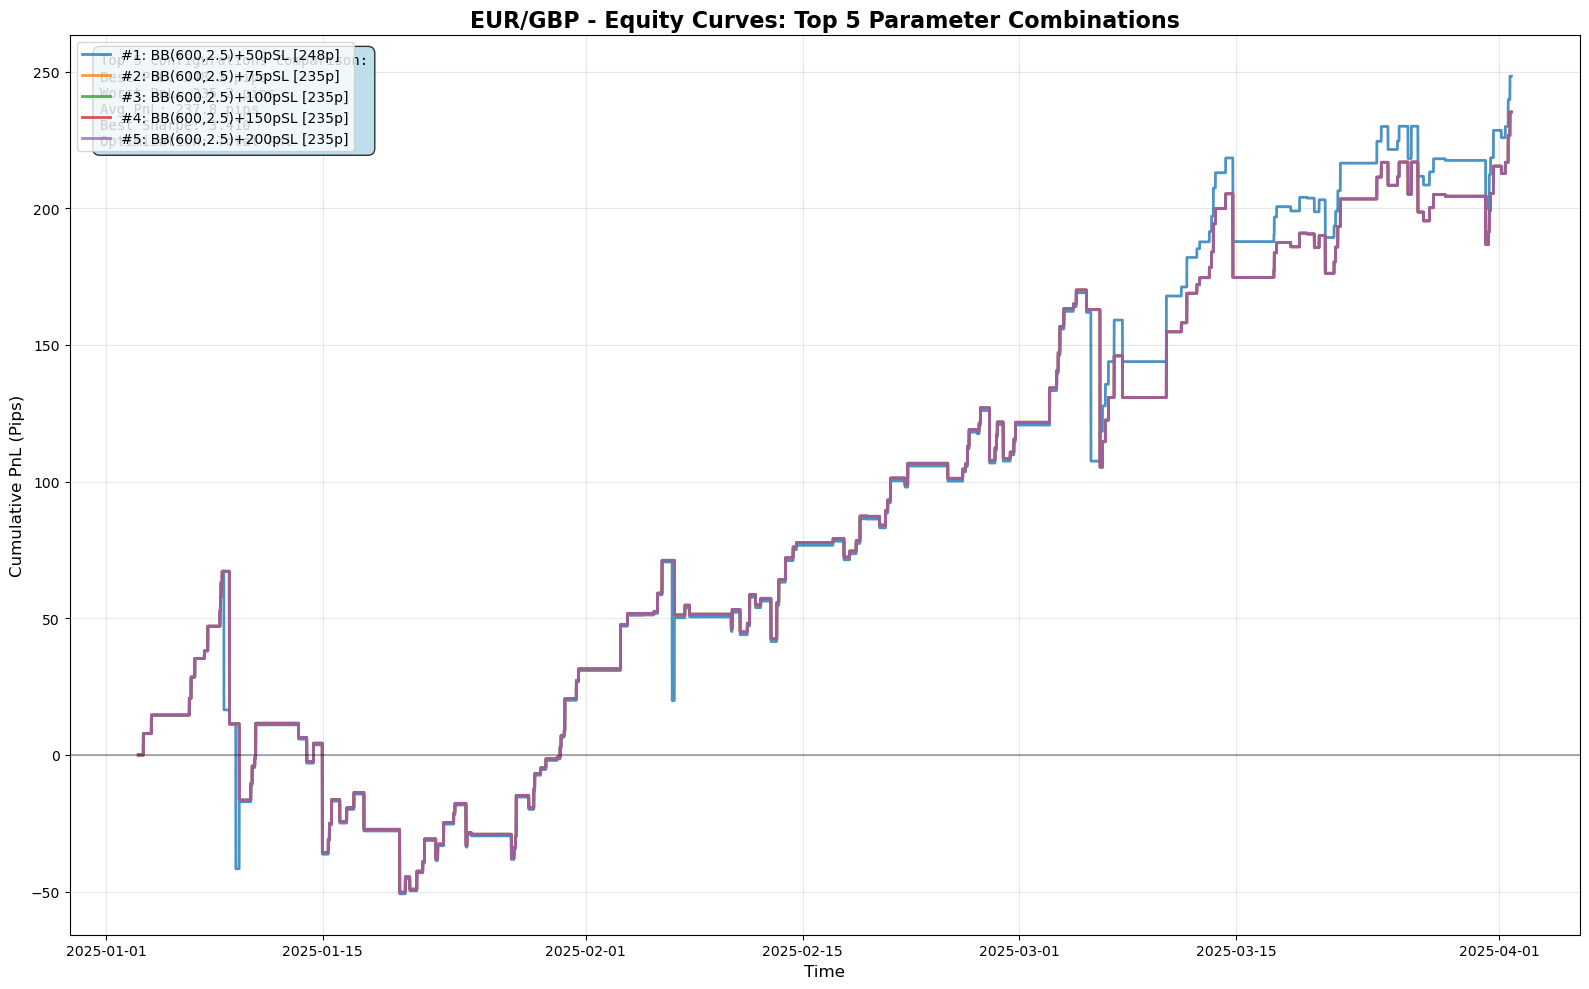


📊 DETAILED COMPARISON - TOP 5 CONFIGURATIONS:

🏆 RANK 1: BB(600,2.5) + 50p Stop Loss
--------------------------------------------------------------------------------
  • Total PnL: 248.30 pips
  • Avg PnL per Trade: 1.43 pips
  • Total Trades: 174
  • Win Rate: 97.7%
  • Loss Rate: 2.3%
  • Max Drawdown: 299.10 pips
  • Sharpe Ratio: 3.212
  • Time in Market: 44.8%
  • Target Exits: 170
  • Stop Loss Exits: 4

🏆 RANK 2: BB(600,2.5) + 75p Stop Loss
--------------------------------------------------------------------------------
  • Total PnL: 235.20 pips
  • Avg PnL per Trade: 1.38 pips
  • Total Trades: 170
  • Win Rate: 100.0%
  • Loss Rate: 0.0%
  • Max Drawdown: 285.40 pips
  • Sharpe Ratio: 3.410
  • Time in Market: 45.6%
  • Target Exits: 170
  • Stop Loss Exits: 0

🏆 RANK 3: BB(600,2.5) + 100p Stop Loss
--------------------------------------------------------------------------------
  • Total PnL: 235.20 pips
  • Avg PnL per Trade: 1.38 pips
  • Total Trades: 170
  • Win Rate: 1

In [70]:
if results_df is not None and len(results_df) > 0:
    print("📈 EQUITY CURVES - TOP 5 PARAMETER COMBINATIONS")
    print("=" * 80)
    
    # Get top 5 results based on the optimization metric
    top_5_configs = results_df.nlargest(5, OPTIMIZATION_METRIC)
    
    # Create figure for equity curves
    plt.figure(figsize=(16, 10))
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Different colors for each curve
    
    print("🔄 Generating equity curves for top 5 configurations...")
    print()
    
    for i, (idx, config) in enumerate(top_5_configs.iterrows()):
        bb_period = int(config['bb_period'])
        bb_std = config['bb_std']
        stop_loss_pips = int(config['stop_loss_pips'])
        
        print(f"{i+1}. BB({bb_period},{bb_std:.1f}) + {stop_loss_pips}p SL | PnL: {config['total_pnl']:.1f}p | Trades: {int(config['total_trades'])}")
        
        # Prepare data for this configuration
        test_data = ohlc_complete.copy()
        
        # Calculate Bollinger Bands
        test_data['bb_middle'] = test_data['close'].rolling(window=bb_period).mean()
        bb_std_series = test_data['close'].rolling(window=bb_period).std()
        test_data['bb_upper'] = test_data['bb_middle'] + (bb_std_series * bb_std)
        test_data['bb_lower'] = test_data['bb_middle'] - (bb_std_series * bb_std)
        
        # Remove NaN rows
        test_data = test_data.dropna().copy()
        
        # Extract arrays for backtesting
        closes = test_data['close'].values
        bb_uppers = test_data['bb_upper'].values
        bb_lowers = test_data['bb_lower'].values
        bb_middles = test_data['bb_middle'].values
        bids = test_data['initial_bid'].values
        asks = test_data['initial_ask'].values
        
        # Run backtest
        positions, entry_prices, pnl_pips, total_trades, stop_loss_trades, exit_reasons = bollinger_backtest_with_stoploss(
            closes, bb_uppers, bb_lowers, bb_middles, bids, asks, stop_loss_pips
        )
        
        # Plot equity curve
        label = f"#{i+1}: BB({bb_period},{bb_std:.1f})+{stop_loss_pips}pSL [{config['total_pnl']:.0f}p]"
        plt.plot(test_data.index, pnl_pips, color=colors[i], linewidth=2, alpha=0.8, label=label)
    
    # Formatting
    plt.title(f'{CURRENCY_PAIR} - Equity Curves: Top 5 Parameter Combinations', fontsize=16, fontweight='bold')
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Cumulative PnL (Pips)', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add horizontal line at zero
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add performance statistics box
    stats_text = f'''Top 5 Configurations Comparison:
Best PnL: {top_5_configs['total_pnl'].max():.1f} pips
Worst PnL: {top_5_configs['total_pnl'].min():.1f} pips
Avg PnL: {top_5_configs['total_pnl'].mean():.1f} pips
Best Sharpe: {top_5_configs['sharpe_ratio'].max():.3f}
Optimization: {OPTIMIZATION_METRIC.replace('_', ' ').title()}'''
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Create detailed comparison table
    print(f"\n📊 DETAILED COMPARISON - TOP 5 CONFIGURATIONS:")
    print("=" * 100)
    
    comparison_metrics = ['bb_period', 'bb_std', 'stop_loss_pips', 'total_pnl', 'avg_pnl_per_trade', 
                         'total_trades', 'win_rate', 'max_drawdown', 'sharpe_ratio']
    
    for i, (idx, config) in enumerate(top_5_configs.iterrows()):
        print(f"\n🏆 RANK {i+1}: BB({int(config['bb_period'])},{config['bb_std']:.1f}) + {int(config['stop_loss_pips'])}p Stop Loss")
        print("-" * 80)
        print(f"  • Total PnL: {config['total_pnl']:.2f} pips")
        print(f"  • Avg PnL per Trade: {config['avg_pnl_per_trade']:.2f} pips")
        print(f"  • Total Trades: {int(config['total_trades'])}")
        print(f"  • Win Rate: {config['win_rate']:.1f}%")
        print(f"  • Loss Rate: {config['loss_rate']:.1f}%")
        print(f"  • Max Drawdown: {config['max_drawdown']:.2f} pips")
        print(f"  • Sharpe Ratio: {config['sharpe_ratio']:.3f}")
        print(f"  • Time in Market: {config['time_in_market']:.1f}%")
        print(f"  • Target Exits: {int(config['target_exits'])}")
        print(f"  • Stop Loss Exits: {int(config['stop_loss_exits'])}")
    
    print(f"\n✅ Equity curves visualization completed!")
    print(f"💡 The chart shows how different parameter combinations perform over time")
    print(f"🎯 Ranking based on: {OPTIMIZATION_METRIC.replace('_', ' ').title()}")

else:
    print("❌ No optimization results available.")
    print("Please run the grid optimization first to generate equity curves.")